# 가중치 시각화
합성곱 층은 여러 개의 필터를 사용해 이미지에서 특징을 학습한다.  
각 필터는 커널이라고 부르는 가중치와 절편을 가지고 있다.  
일반적으로 절편은 시각적으로 의미가 있지 않다.  
가중치는 입력 이미지의 2차원 영역에 적용되어 어떤 특징을 크게 두드러지게 표현하는 역할을 한다.  



--- 
7-2 에서 만들었던 파일을 세션에 업로드해서 사용  
매 세션마다 초기화 됌으로 수동 업로드  
아니면 아래 ! 명령 사용  
  
---

In [1]:
from tensorflow import keras
#model = keras.models.load_model('best-cnn-model.h5') # 수동으로 7-2 파일을 넣어주고 실행하는 방법

In [5]:
# 깃허브에서 가져옴
!wget https://github.com/rickiepark/hg-mldl/raw/master/best-cnn-model.h5
model = keras.models.load_model('best-cnn-model.h5')

--2023-04-16 03:03:19--  https://github.com/rickiepark/hg-mldl/raw/master/best-cnn-model.h5
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/hg-mldl/master/best-cnn-model.h5 [following]
--2023-04-16 03:03:20--  https://raw.githubusercontent.com/rickiepark/hg-mldl/master/best-cnn-model.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4046712 (3.9M) [application/octet-stream]
Saving to: ‘best-cnn-model.h5.2’

best-cnn-model.h5.2 100%[===================>]   3.86M  --.-KB/s    in 0.08s   

2023-04-16 03:03:20 (46.9 MB/s) - ‘best-cnn-model.h5.2’ saved [4046712/4046712]



이 파일의 레이어를 출력해보자

In [6]:
model.layers

레이어를 살펴보면 Conv2D, MaxPooling2D, Flatten  
Dense, Dropout이 있는 걸 알 수 있다.  

---
첫번째 합성곱 층의 가중치를 확인해보자

In [7]:
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


커널의 크기는 (3, 3)이고 합성곱층에 전달되는 입력의 깊이는 1이므로 커널의 크기는 (3, 3, 1) 이다.  
필터가 32이므로 (3, 3, 1, 32)이다.  
weights 두 번째 원소는 절편의 개수를 나타낸다.  
필터마다 하나의 절편이 있으므로 (32,) 크기가 된다.  

In [8]:
conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(), conv_weights.std())

-0.013060082 0.23505393


가중치의 평균값은 0에 가깝고 표준편차는 0.24정도다.  
히스토그램으로 표현해보자

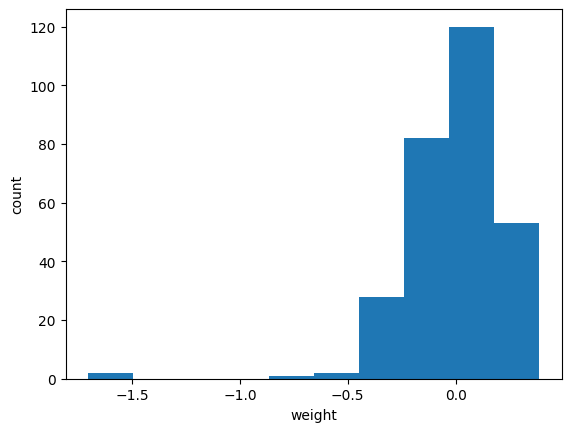

In [9]:
import matplotlib.pyplot as plt
plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

32개의 커널을 16개씩 두줄로 출력

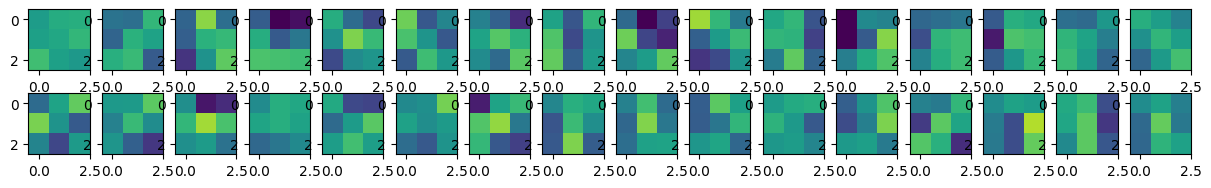

In [10]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
  for j in range(16):
    axs[i, j].imshow(conv_weights[:,:,0,i*16 + j], vmin = -0.5, vmax= 0.5)
plt.show()

밝은 쪽이 값이 높다.

이번엔 훈련하지 않은 빈 합성곱 신경망을 만들어보자

In [14]:
no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu', padding='same', input_shape = (28, 28, 1)))

이 모델의 첫 번쨰 층의 가중치를 no_training_conv에 저장

In [15]:
no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


가중치가 앞서 출력한 그래프와 같다.  
이 가중치의 평균과 표준편차를 확인해보자

In [16]:
no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(), no_training_weights.std())

-0.0041194092 0.08178501


평균은 0에 가깝지만 표쥰편차는 매우 작다.  
히스토그램으로 그려보자

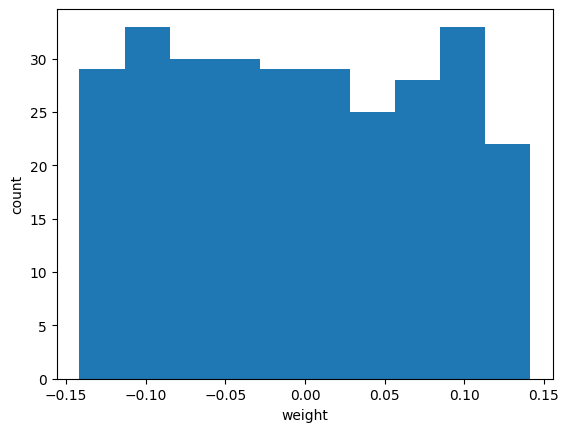

In [17]:
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

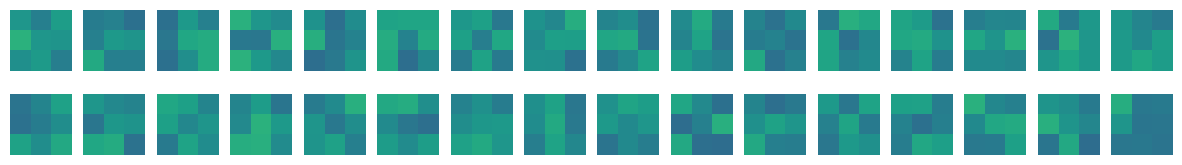

In [18]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
  for j in range(16):
    axs[i, j].imshow(no_training_weights[:,:,0,i*16 + j], vmin = -0.5, vmax= 0.5)
    axs[i, j].axis('off')
plt.show()

이전과는 다르게 가중치가 밋밋하게 변했다.  
합성곱 신경망이 패션 MNIST 데이터셋의 분류 정확도를 높이기 위해 유용한 패턴을 학습한 것이다.  

---

모델 입력 데이터를 출력해보자

In [19]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")


이제 model.input과 model.layers[0].output을 연결하는 새로운 conv_acti 모델을 만들자

In [21]:
conv_acti = keras.Model(model.input, model.layers[0].output)

준비가 끝났으니 특성 맵 시각화를 시작해 보자

# 특성 맵 시각화
케라스로 데이터셋을 읽고 훈련세트의 첫 번째 샘플을 그려보자

4422102/4422102 [==============================] - 1s 0us/step


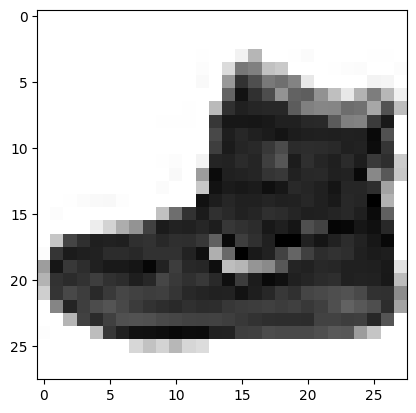

In [25]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap = 'gray_r')
plt.show()

앵클부츠가 나왔다.  
이걸 conv_acti 모델에 주입해서 Conv2D 층이 만드는 특성 맵을 출력해보자  
슬라이딩 연산자를 사용해 첫 번째 샘플을 선택, 그 다음에 (784,)크기를  
(28, 28, 28 ,1)로 하고 255로 나눈다.  

In [26]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv_acti.predict(inputs)

1/1 [==============================] - 0s 409ms/step


In [28]:
# feature_maps 크기를 확인
print(feature_maps.shape)

(1, 28, 28, 32)


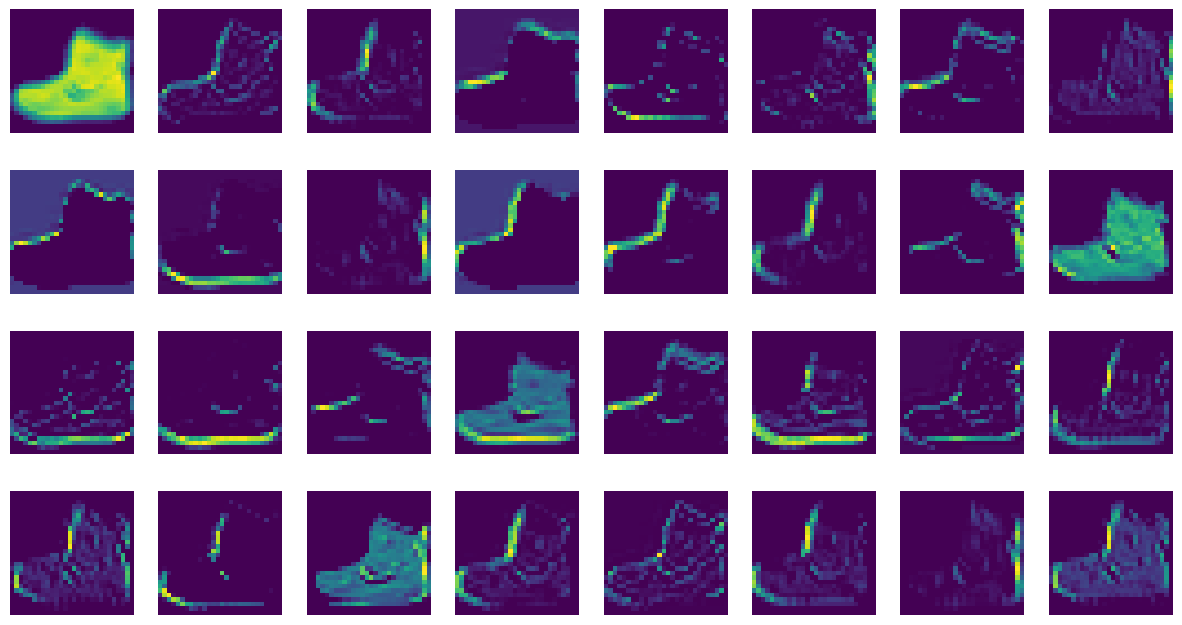

In [29]:
fig, axs = plt.subplots(4, 8, figsize = (15, 8))
for i in range(4):
  for j in range(8):
    axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
    axs[i, j].axis('off')
plt.show()

이 특성맵은 32개의 필터로 인해 입력 이미지에서 강하게 활성화된 부분을 보여준다.  
두 번째 합성곱 층이 만든 특성 맵도 같은 방식으로 확인할 수 있다.

In [31]:
conv2_acti = keras.Model(model.input, model.layers[2].output)

이걸 predict 메서드에 전달

In [32]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv2_acti.predict(inputs)

1/1 [==============================] - 0s 78ms/step


첫 번째 풀링 층에서 가로세로 크기가 반으로 감소하고 두 번째 합성곱 층의 필터는 64개다.  
맞는지 확인해보자

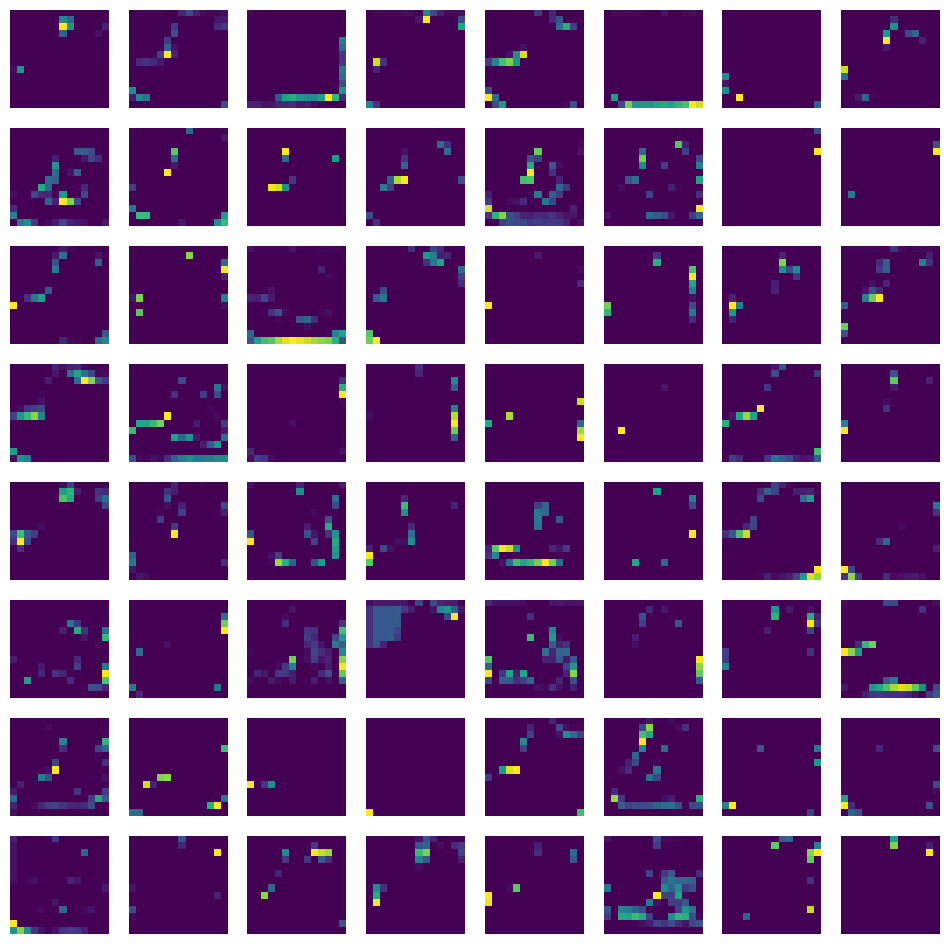

In [33]:
fig, axs = plt.subplots(8, 8, figsize = (12, 12))
for i in range(8):
  for j in range(8):
    axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
    axs[i, j].axis('off')
plt.show()

뭐가 뭔지 알기 어렵다. 왜 이런 결과가 나올까?  
두 번째 합성곱 층의 필터는 (3, 3, 32)다.  
이 두개가 서로 계산되면서 결과 적으로 어떤 부위를 감지하는지 다소 어렵게 나온다.  
바꾸어 생각하면 합성곱 층은 이미지의 시각적인 정보를 감지하고  
뒤쪽에 있는 합성곱 층은 앞쪽에서 감지한 시각적인 정보를 바탕으로  
추상적인 정보를 학습한다고 볼 수 있다.  

# 정리
### 가중치 시각화
가중치 시각화는 합성곱 층의 가중치를 이미지로 출력하는 것이다.  
가중치가 시각적인 패턴을 학습하는지 알아볼 수 있다.  
### 특성 맵 시각화
특성 맵 시각화는 합성곱 층의 활성화 출력을 이미지로 그리는 것을 말한다.  
가중치 시각화와 함께 비교하여 각 필터가 이미지의 어느 부분을 활성화 시키는지  
알 수 있다.  
### 함수형 API
케라스에서 신경망 모델을 만다는 방법 중 하나로  
Model클래스에 입출력을 지정한다.  
전형적으로 입력은 Input() 함수를 사용하고  
출력은 마지막 층의 출력으로 정의한다.  